In [1]:
from pca_plots import *
from writhe import *
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [2]:
# load in trajectory and pdb, can make this into an argument in the future 
trajectory = "./drkN_c22star.dcd"
pdb = "./drkN.pdb"
outdir='./outdir_c22star/'
sys = os.path.splitext(os.path.basename(pdb))[0]

# can possibly automate this to search for pdb, and add that root, but would need to stop adding dots in pdb/dcd files
if not os.path.exists('outdir_c22star'):
    os.makedirs('outdir_c22star')

trj = md.load(trajectory, top=pdb)

Make sure everything is good with the topology file and what was read in! 

In [3]:
first_frame = 0
last_frame = trj.n_frames
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 939

Number of residues: 59

Number of frames: 20000

Starting frame: 0

Last frame: 20000

sequence:  [MET1, GLU2, ALA3, ILE4, ALA5, LYS6, HIS7, ASP8, PHE9, SER10, ALA11, THR12, ALA13, ASP14, ASP15, GLU16, LEU17, SER18, PHE19, ARG20, LYS21, THR22, GLN23, ILE24, LEU25, LYS26, ILE27, LEU28, ASN29, MET30, GLU31, ASP32, ASP33, SER34, ASN35, TRP36, TYR37, ARG38, ALA39, GLU40, LEU41, ASP42, GLY43, LYS44, GLU45, GLY46, LEU47, ILE48, PRO49, SER50, ASN51, TYR52, ILE53, GLU54, MET55, LYS56, ASN57, HIS58, ASP59]

residue names:  ['MET', 'GLU', 'ALA', 'ILE', 'ALA', 'LYS', 'HIS', 'ASP', 'PHE', 'SER', 'ALA', 'THR', 'ALA', 'ASP', 'ASP', 'GLU', 'LEU', 'SER', 'PHE', 'ARG', 'LYS', 'THR', 'GLN', 'ILE', 'LEU', 'LYS', 'ILE', 'LEU', 'ASN', 'MET', 'GLU', 'ASP', 'ASP', 'SER', 'ASN', 'TRP', 'TYR', 'ARG', 'ALA', 'GLU', 'LEU', 'ASP', 'GLY', 'LYS', 'GLU', 'GLY', 'LEU', 'ILE', 'PRO', 'SER', 'ASN', 'TYR', 'ILE', 'GLU', 'MET', 'LYS', 'ASN', 'HIS', 'ASP']

residue number:  [1, 2, 

Get some info on the trajectory without PCA 

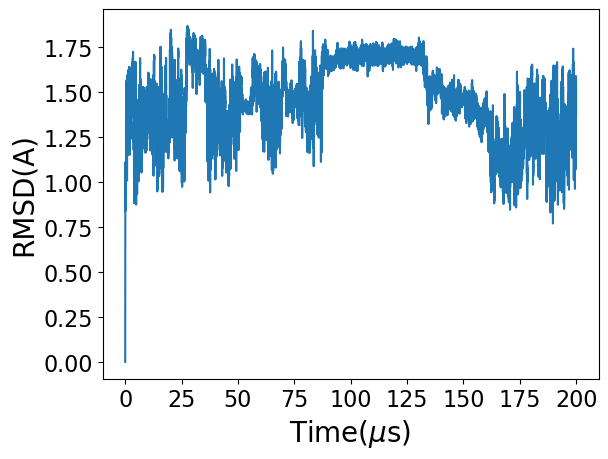

<Figure size 640x480 with 0 Axes>

In [4]:
# RMSD from first frame 
trjCA = md.load(trajectory, top=pdb)
CA=trjCA.top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()
CA_trj_sel=trj.topology.select("name CA")
rmsd = md.rmsd(trjCA, trjCA[0])
plt.plot(np.linspace(0,200,trjCA.n_frames),rmsd)
plt.xlabel("Time($\mu$s)",size=20)
plt.ylabel("RMSD(A)", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()
plt.clf()

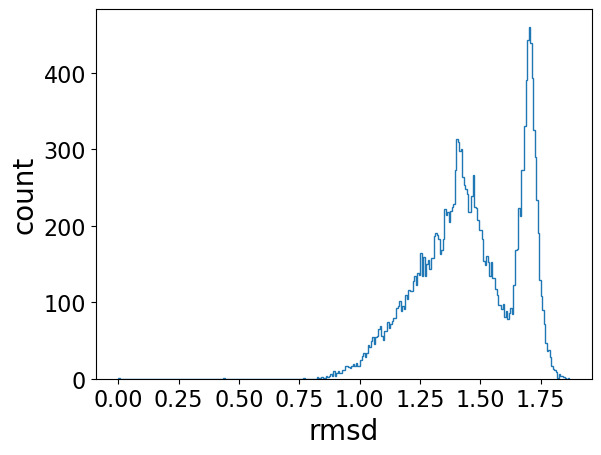

In [5]:
plt.hist(rmsd,histtype='step',bins=300)
plt.xlabel("rmsd", size=20)
plt.ylabel("count", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [6]:
trjBB = md.load(trajectory, top=pdb)
BB=trjBB.top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()
x = [res.resSeq for res in trjBB.top.residues]
dssp=md.compute_dssp(trjBB,simplified=True)

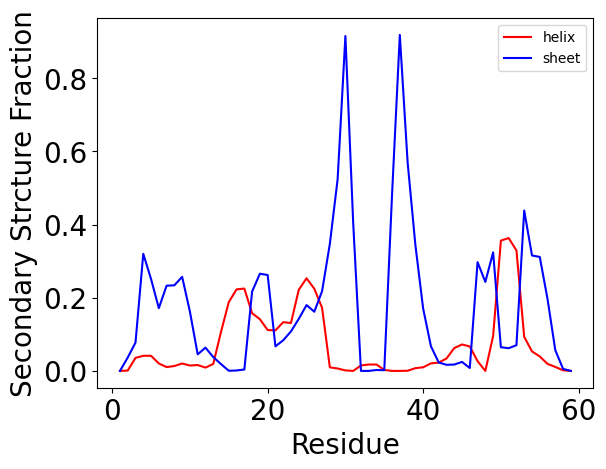

In [7]:
def dssp_convert(dssp):
    dsspH=np.copy(dssp)
    dsspE=np.copy(dssp)
    
    dsspH[dsspH=='H']=1 # helix                                                                                  
    dsspH[dsspH=='E']=0 # extended strand                                                                              
    dsspH[dsspH=='C']=0 # coil                                                                                  
    dsspH[dsspH=='NA']=0 # don't know 
    dsspH=dsspH.astype(int) # cast to int 
    TotalH=np.sum(dsspH,axis=1) 
    Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

    dsspE[dsspE=='H']=0
    dsspE[dsspE=='E']=1
    dsspE[dsspE=='C']=0
    dsspE[dsspE=='NA']=0
    dsspE=dsspE.astype(int)
    TotalE=np.sum(dsspE,axis=1) 
    Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
    return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(x,Hprop,c='r',label='helix')
plt.plot(x,Eprop,c='b',label='sheet')

plt.legend(loc="upper right")
plt.xlabel('Residue', size=20)
plt.xticks(size=16)
plt.ylabel('Secondary Strcture Fraction', size=20)
plt.yticks(size=16)
plt.tick_params(labelsize=20)
plt.show()

In [8]:
trj.n_frames

20000

In [9]:
CAlabel, wr_total, wr_by_res, writhe_matrx, w_model_input, CAatoms = W_ij(trj)
trj.superpose(trj, 0)
c_model_input, contacts, contact_avg = make_contact_map(len(CAlabel)) # could change to len(CAlabel)? 

# create a new cmap to make background white 
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)

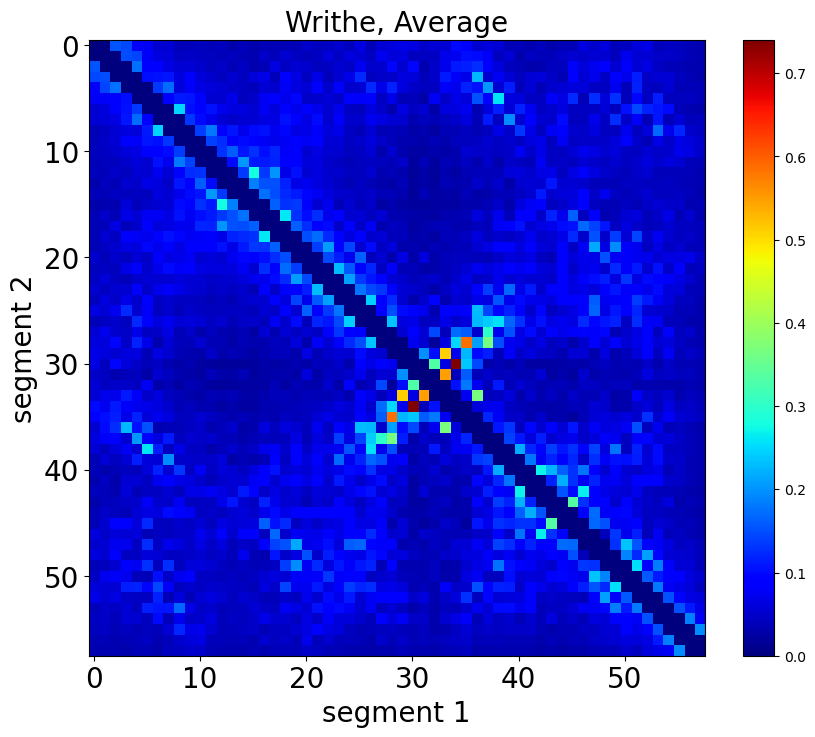

In [10]:
plt_avg_matrx(writhe_matrx, title="Writhe, Average", count=0)

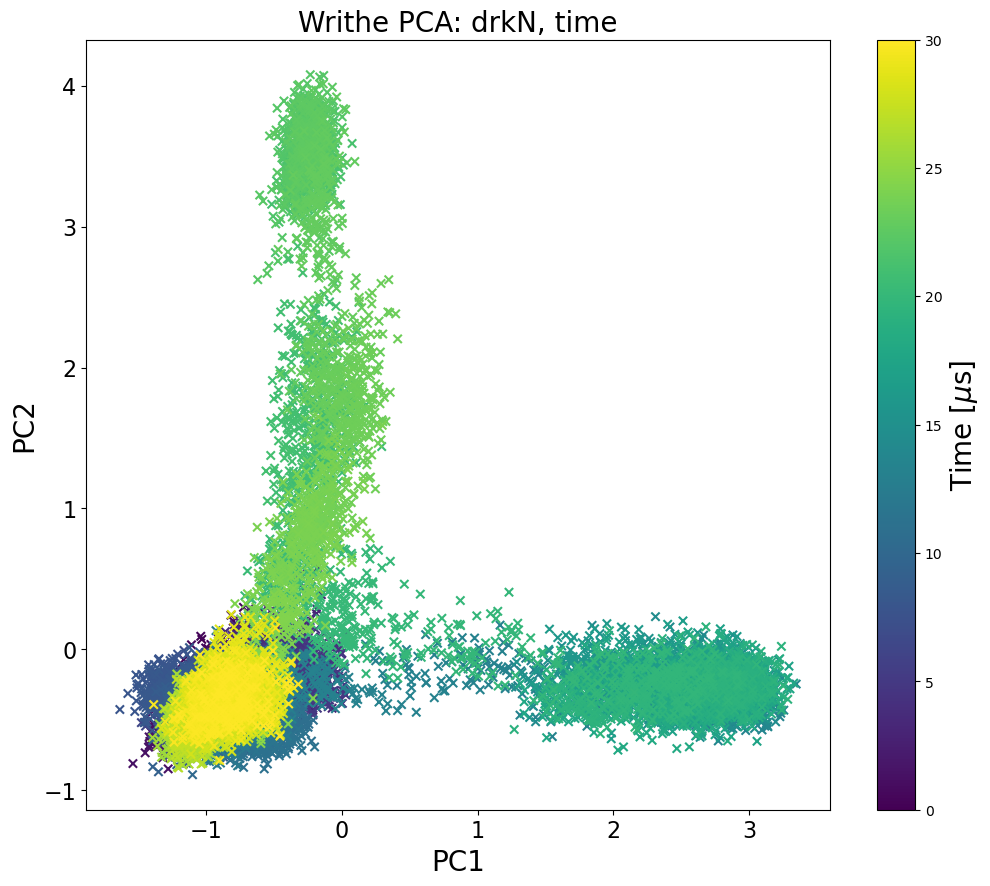

In [11]:
# PCA writhe 
WPC1, WPC2 = pca(w_model_input)
plt_project_time(WPC1, WPC2, trj.n_frames, time=30, title= 'Writhe PCA: drkN, time') 

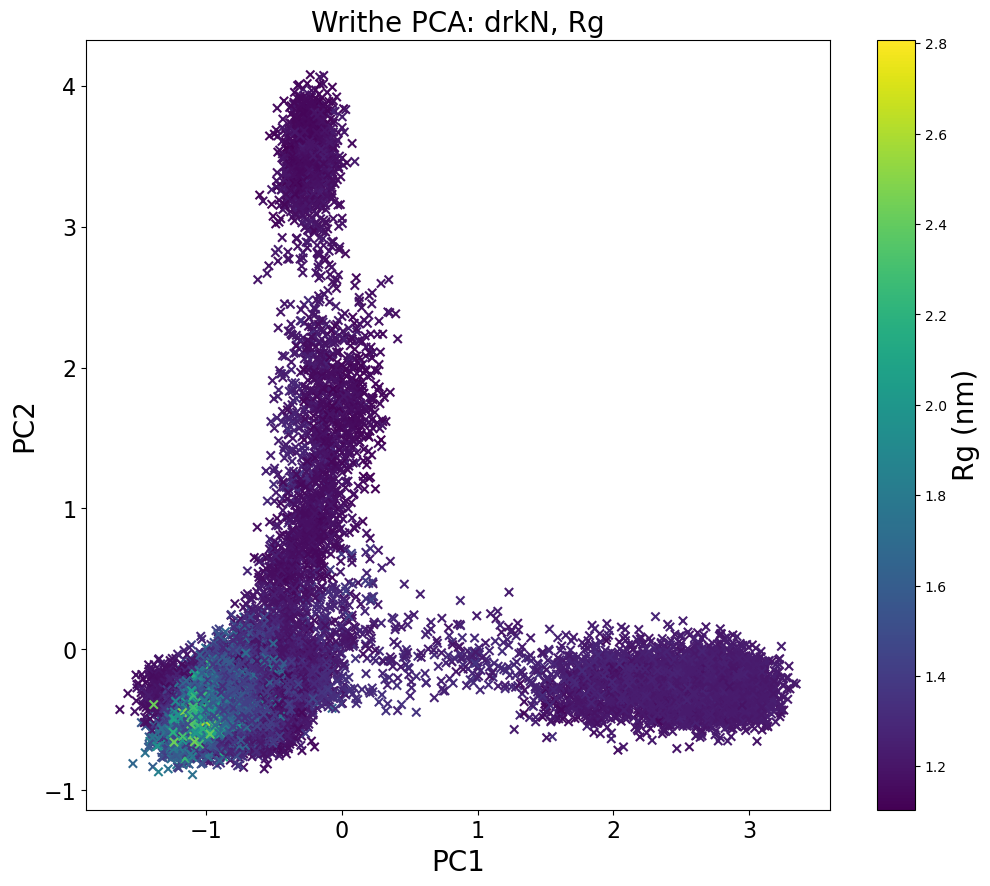

In [12]:
plt_project_rg(WPC1, WPC2, trj, title= "Writhe PCA: drkN, Rg")

In [73]:
# PCA Writhe Eigenvector analysis 
wmodel = PCA(n_components=2)
wmodel.fit(w_model_input)
print(np.sum(wmodel.explained_variance_ratio_))
print(wmodel.explained_variance_ratio_[0])
print(wmodel.explained_variance_ratio_[1])

0.15038428294669648
0.10077299352782047
0.04961128941887602


In [15]:
def reconstruct_matrx(pca, n_components=2, num_res=20): 
    reconstructed_matrices = np.empty((num_res-1,num_res-1,n_components))
    
    rev = np.flip(np.arange(1, num_res-2))
    for n in range(n_components): 
        # grab eigenvalue 
        eigh = pca.components_[n,:]
        matrx = np.zeros((num_res-1,num_res-1))
        
        # reconstruct the matrix 
        count = 0 
        for k in range(2, num_res-1): # starts at 2 because of hack
            val = eigh[:rev[count]]
            eigh = eigh[rev[count]:]
            matrx[count][k:] = val
            #matrx[rev[count]+1][:rev[count]] = np.flip(val)
            count += 1 
        
        
        # do other side of matrix 
        for i in range(num_res-1): 
            for j in range(i+1, num_res-1):
                matrx[j][i] = matrx[i][j]
        
        reconstructed_matrices[:,:,n] = matrx
        
    return reconstructed_matrices

In [16]:
reconstructed_matrices = reconstruct_matrx(wmodel, 2, 59)
matrx_e1 = reconstructed_matrices[:,:,0]
matrx_e2 = reconstructed_matrices[:,:,1]

In [17]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

seq=[]
for i in range(len(sequence)-1): 
    seq.append(str(sequence[i]) + "-"+ str(sequence[i+1]))

# get rid of some 
n=2
for i in range (0,len(seq)): 
    if (i % n !=0):
        seq[i]=''
        
print(len(seq))

58


In [18]:
print(np.amin(matrx_e1), np.amax(matrx_e1), np.amin(matrx_e2), np.amax(matrx_e2))

-0.074981421838226 0.20584579055698565 -0.057500475224451134 0.1932467828065232


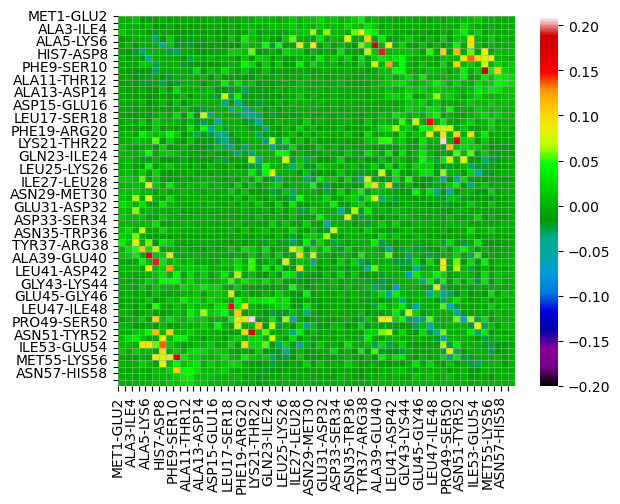

In [23]:
ax = sns.heatmap(matrx_e1, vmin=-0.2, vmax=0.21,cmap=n_cmap)
#ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,58))
ax.set_yticks(range(0,58))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

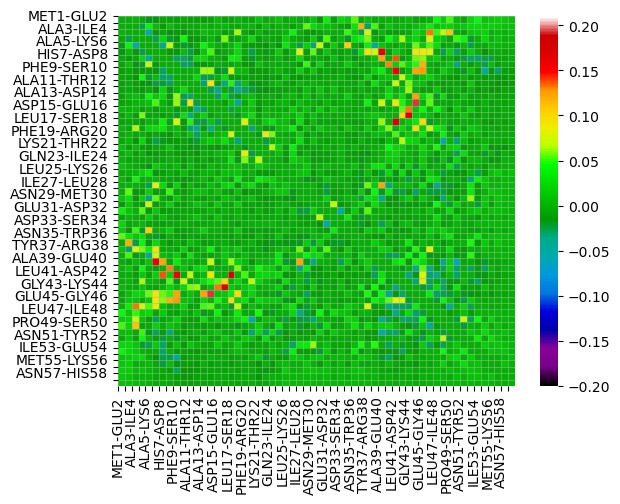

In [24]:
ax = sns.heatmap(matrx_e2, vmin=-0.2, vmax=0.21,cmap=n_cmap)
#ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,58))
ax.set_yticks(range(0,58))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

In [29]:
# Kmeans clustering
concat = np.column_stack((WPC1, WPC2))
X = concat
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)
centers

array([[-0.23304151,  3.43346208],
       [-0.83263597, -0.36201047],
       [ 2.52014958, -0.26727921],
       [-0.13571523,  1.22341799]])

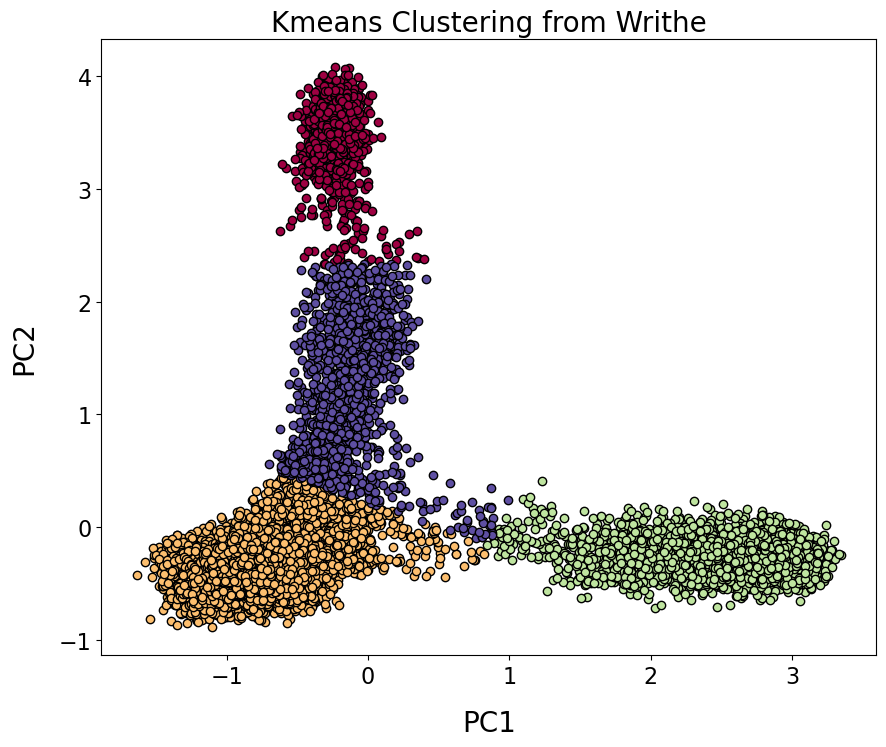

In [30]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

    """xy = X[class_member_mask] #  & ~core_samples_mask
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )"""
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Writhe", size = 20, loc="center")
plt.savefig(outdir+'writhe_kmeans_clustering.png',dpi=200)

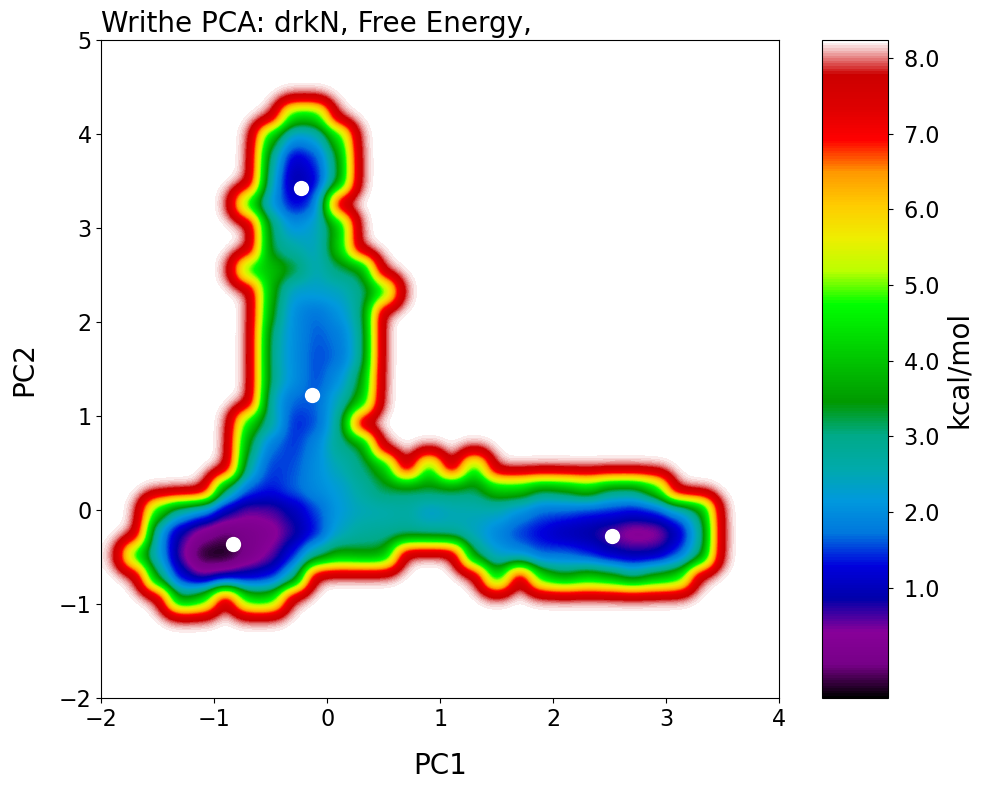

In [37]:
plt_free_energy(WPC1, WPC2, n_cmap, centers, True, title="Writhe PCA: drkN, Free Energy,", xmin=-2, xmax=4, ymin=-2, ymax=5)

In [32]:
# get every basin and save it 
wbasin1 = np.where(labels == 0)[0]
wbasin2 = np.where(labels == 1)[0]
wbasin3 = np.where(labels == 2)[0]
wbasin4 = np.where(labels == 3)[0]
# writhe_basin_trj = trj.slice(wbasin1)
# writhe_basin_trj.save_dcd(outdir + "kmeans_writhe_basin1_trj.dcd")
# writhe_basin_trj = trj.slice(wbasin2)
# writhe_basin_trj.save_dcd(outdir + "kmeans_writhe_basin2_trj.dcd")
# writhe_basin_trj = trj.slice(wbasin3)
# writhe_basin_trj.save_dcd(outdir + "kmeans_writhe_basin3_trj.dcd")
# writhe_basin_trj = trj.slice(wbasin4)
# writhe_basin_trj.save_dcd(outdir + "kmeans_writhe_basin4_trj.dcd")

In [43]:
# check what size, since finding a centroid is O(n^2), 
print(wbasin1.size/1000, wbasin2.size/1000, wbasin3.size/1000, wbasin4.size/1000)

1.181 12.889 4.449 1.481


STOPPED HERE

In [31]:
# get centroids 
traj_basin = md.load(outdir + "kmeans_writhe_basin1_trj.dcd", top=pdb, stride=1)
atom_indices = [a.index for a in traj_basin.topology.atoms if a.element.symbol != 'H']
distances = np.empty((traj_basin.n_frames, traj_basin.n_frames))
for i in range(traj_basin.n_frames):
    distances[i] = md.rmsd(traj_basin, traj_basin, i, atom_indices=atom_indices)

beta = 1
index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
print(index)

centroid = traj_basin[index]
print(centroid)

912
<mdtraj.Trajectory with 1 frames, 939 atoms, 59 residues, and unitcells>


I wasn't able to calcualte the centroids for the entire trajectory b/c of the time, so here are the strides I used 

- Basin 1: 912
- Basin 2: 447
- Basin 3: 881
- Basin 4: 1014
Now, let's print out the average writhe for each basin 

In [ ]:
# basin1 = locate_basin(WPC1,WPC2, (-1,0.5,-1,0.5))


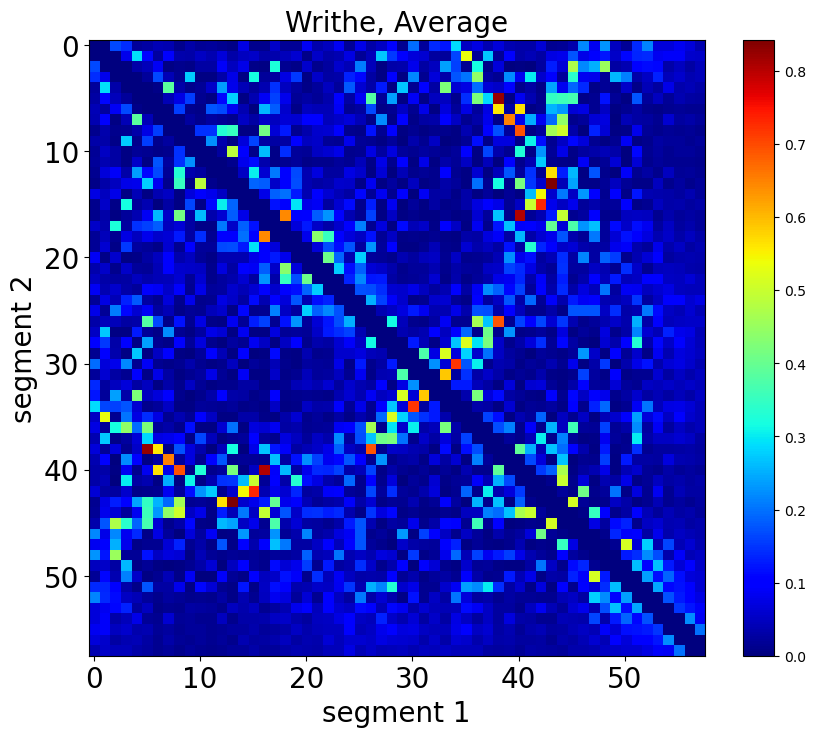

In [33]:
w_matrx_b1 = writhe_avg_from_ind(wr_total, CAlabel, wbasin1)
plt_avg_matrx(w_matrx_b1, title="Writhe, Average", count=0)

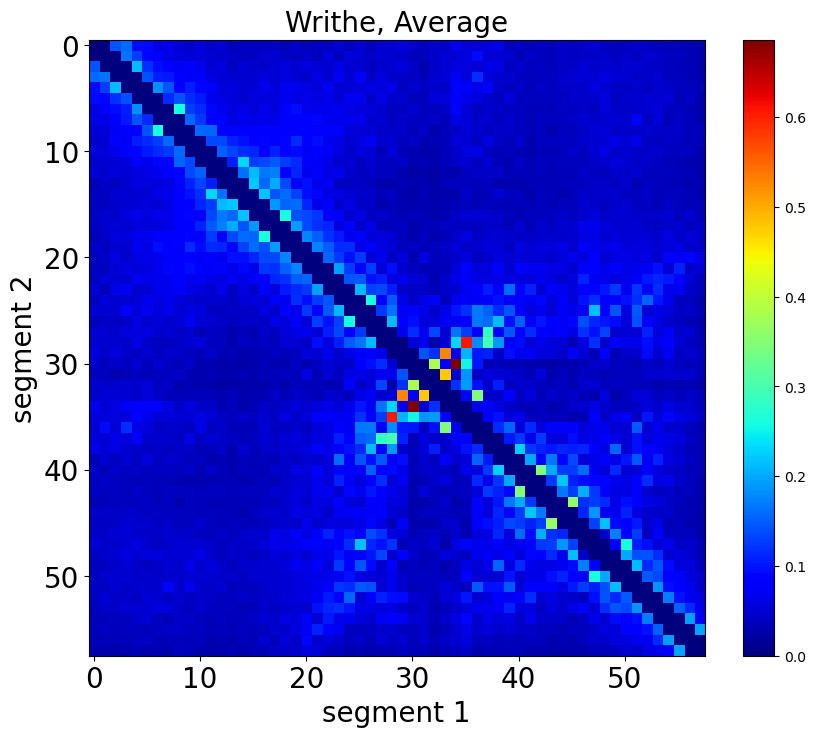

In [34]:
#basin2 = locate_basin(WPC1,WPC2, (0.5,1,-1,0))
w_matrx_b2 = writhe_avg_from_ind(wr_total, CAlabel, wbasin2)
plt_avg_matrx(w_matrx_b2, title="Writhe, Average", count=0)

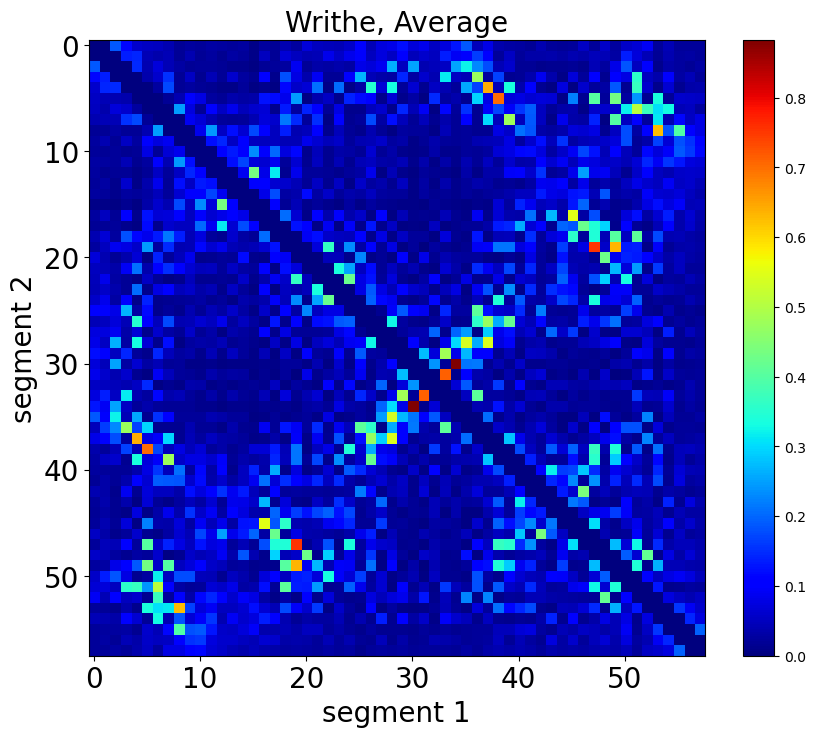

In [35]:
#basin3 = locate_basin(WPC1,WPC2, (-0.5,0.5,0.5,1.5))
w_matrx_b3 = writhe_avg_from_ind(wr_total, CAlabel, wbasin3)
plt_avg_matrx(w_matrx_b3, title="Writhe, Average", count=0)

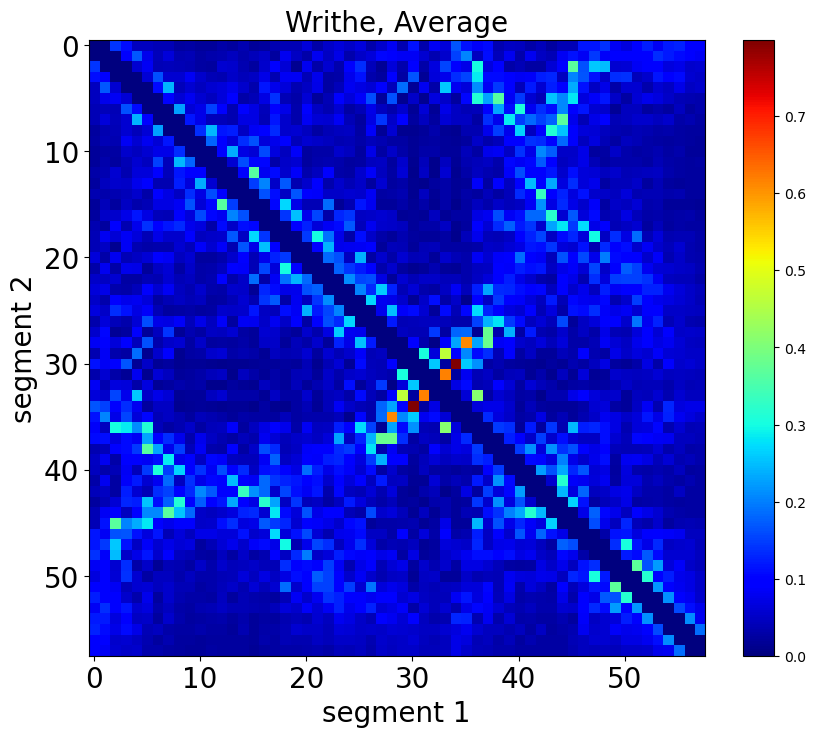

In [36]:
#basin4 = locate_basin(WPC1,WPC2, (-1,0,1.5,3))
w_matrx_b4 = writhe_avg_from_ind(wr_total, CAlabel, wbasin4)
plt_avg_matrx(w_matrx_b4, title="Writhe, Average", count=0)

In [48]:
wcontact_basin1 = contact_map_avg(contacts, 59, wbasin1)
wcontact_basin2 = contact_map_avg(contacts, 59, wbasin2)
wcontact_basin3 = contact_map_avg(contacts, 59, wbasin3)
wcontact_basin4 = contact_map_avg(contacts, 59, wbasin4)

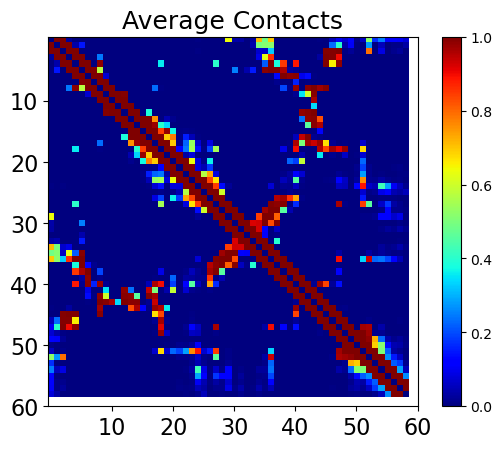

In [76]:
plt.imshow(wcontact_basin1,cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 59, step=10), size=16)
plt.yticks(np.arange(0, 59, step=10), size=16)
plt.colorbar()

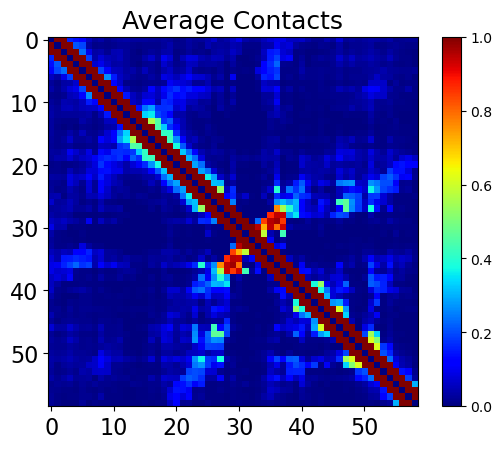

In [50]:
plt.imshow(wcontact_basin2,cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 59, step=10), size=16)
plt.yticks(np.arange(0, 59, step=10), size=16)
plt.colorbar()

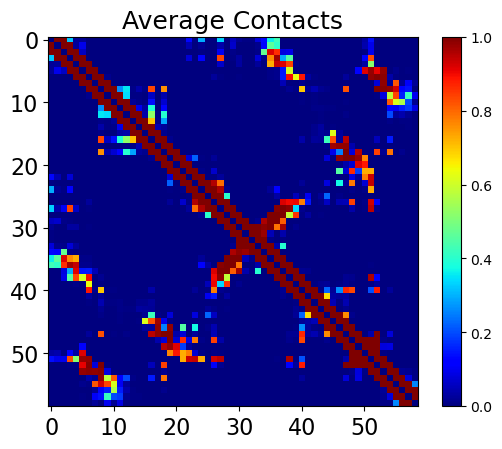

In [51]:
plt.imshow(wcontact_basin3,cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 59, step=10), size=16)
plt.yticks(np.arange(0, 59, step=10), size=16)
plt.colorbar()

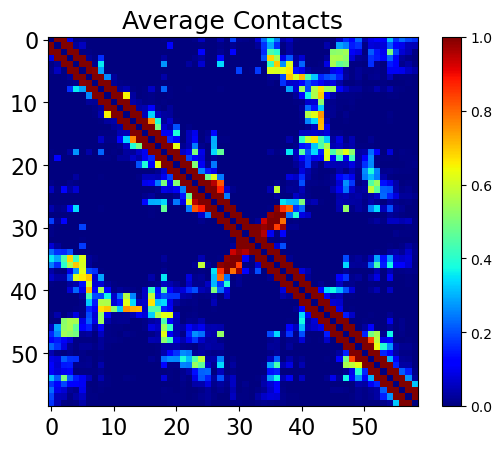

In [52]:
plt.imshow(wcontact_basin4,cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 59, step=10), size=16)
plt.yticks(np.arange(0, 59, step=10), size=16)
plt.colorbar()

In [ ]:
# # there could be another basin? this was from last time... 
# basin5 = locate_basin(WPC1,WPC2, (1.5,3,-0.5,0.5))
# w_matrx_b5 = writhe_avg_from_ind(wr_total, CAlabel, basin5)
# plt_avg_matrx(w_matrx_b5, title="Writhe, Average", count=0)

In [66]:
# PCA contacts 
CPC1, CPC2 = pca(c_model_input)

In [38]:
# PCA Writhe Eigenvector analysis 
cmodel = PCA(n_components=2)
cmodel.fit(c_model_input)
print(np.sum(cmodel.explained_variance_ratio_))
print(cmodel.explained_variance_ratio_[0])
print(cmodel.explained_variance_ratio_[1])

0.22122201185245963
0.14922552999015123
0.07199648186230839


In [39]:
reconstructed_matrices = reconstruct_matrx(cmodel, 2, 59)
cmatrx_e1 = reconstructed_matrices[:,:,0]
cmatrx_e2 = reconstructed_matrices[:,:,1]

In [75]:
trj.n_residues

59

In [41]:
print(np.amin(cmatrx_e1), np.amax(cmatrx_e1), np.amin(cmatrx_e2), np.amax(cmatrx_e2))

-0.044674462039580455 0.08714852783386796 -0.0506002388559279 0.09204794186013344


In [42]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

seq=[]
for i in range(len(sequence)-1): 
    seq.append(str(sequence[i]))

# get rid of some 
n=2
for i in range (0,len(seq)): 
    if (i % n !=0):
        seq[i]=''
        
print(len(seq))

58


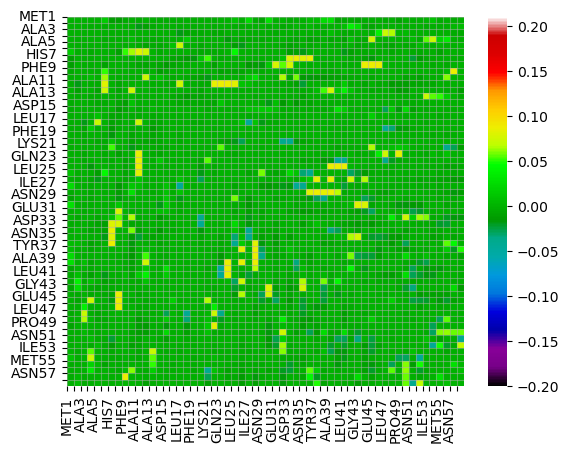

In [47]:
ax = sns.heatmap(cmatrx_e1, vmin=-0.2, vmax=0.21,cmap=n_cmap)
#ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,58))
ax.set_yticks(range(0,58))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

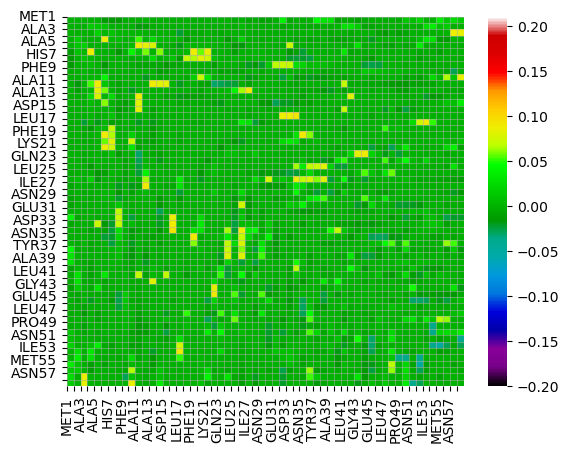

In [44]:
ax = sns.heatmap(cmatrx_e2, vmin=-0.2, vmax=0.21,cmap=n_cmap)
#ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,58))
ax.set_yticks(range(0,58))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

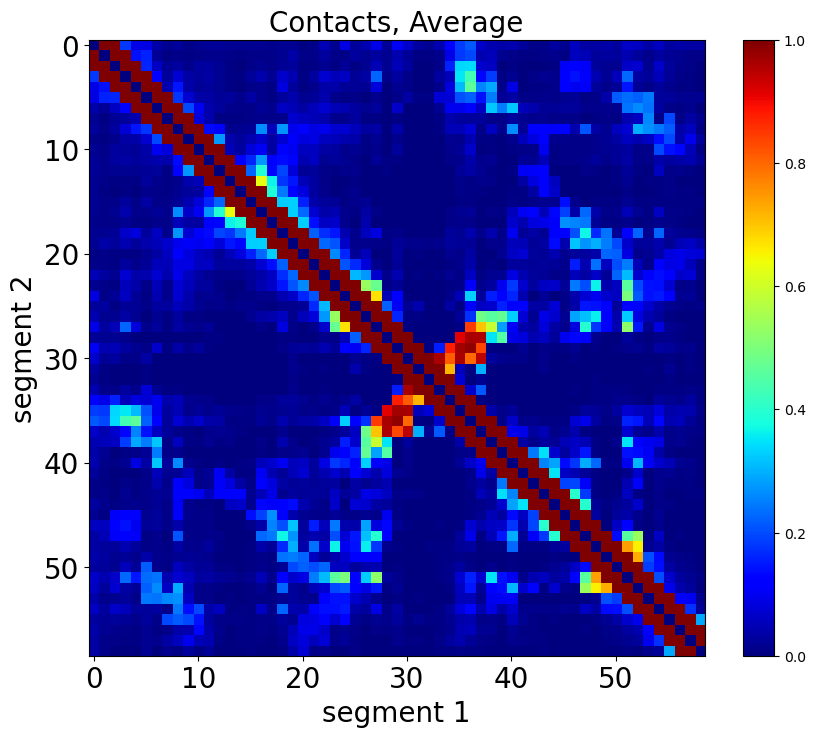

In [27]:
plt_avg_matrx(contact_avg, title="Contacts, Average", count=0)

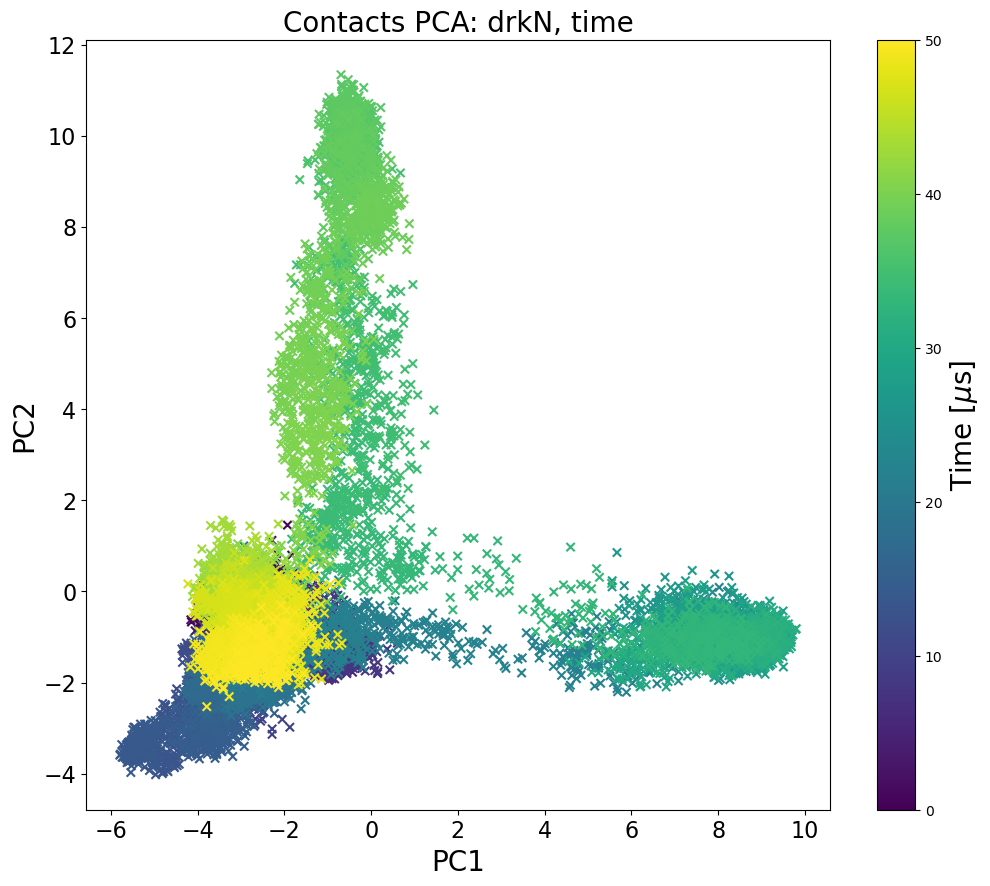

In [28]:
plt_project_time(CPC1, CPC2,trj.n_frames, time=50, title= 'Contacts PCA: drkN, time')

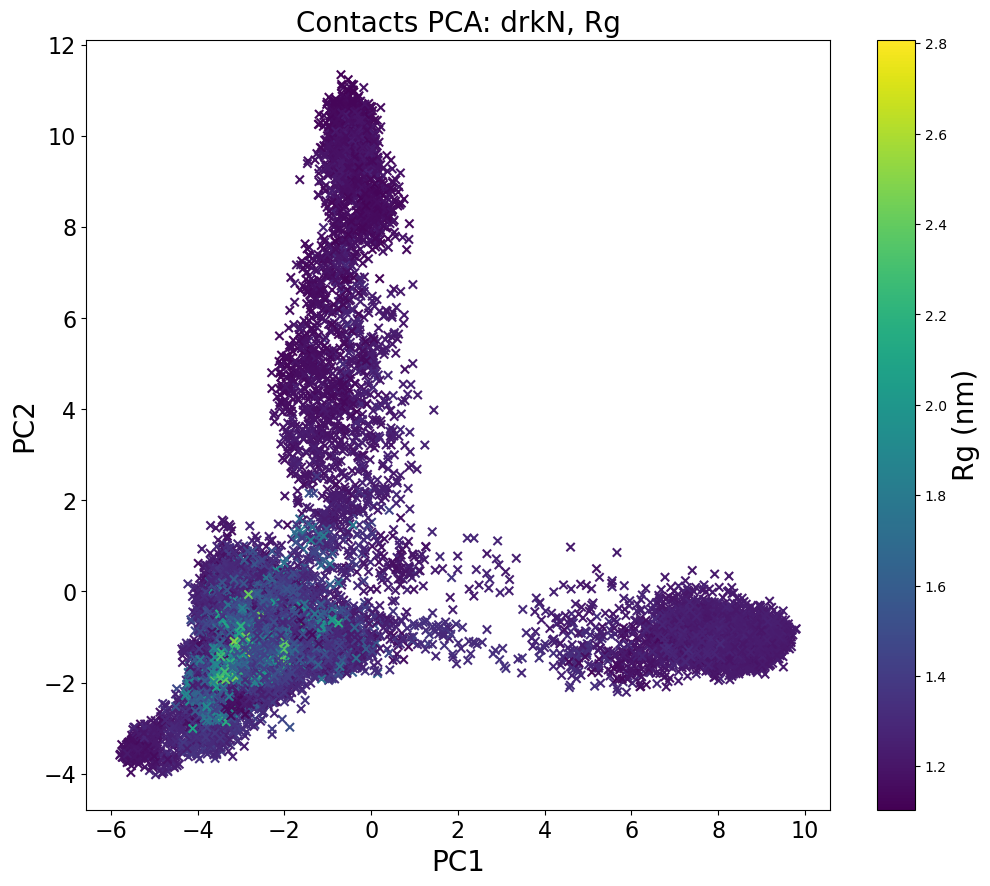

In [29]:
plt_project_rg(CPC1, CPC2, trj, title= "Contacts PCA: drkN, Rg")

In [67]:
# kmeans should figure this out on the notebook :) 
# Kmeans clustering
concat = np.column_stack((CPC1, CPC2))
X = concat
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)
centers

array([[-2.77364292, -1.21342063],
       [ 8.08073435, -0.99496125],
       [-0.44394429,  9.20928607],
       [-0.66825582,  3.48559156]])

Text(0.5, 1.0, 'Kmeans Clustering from Writhe')

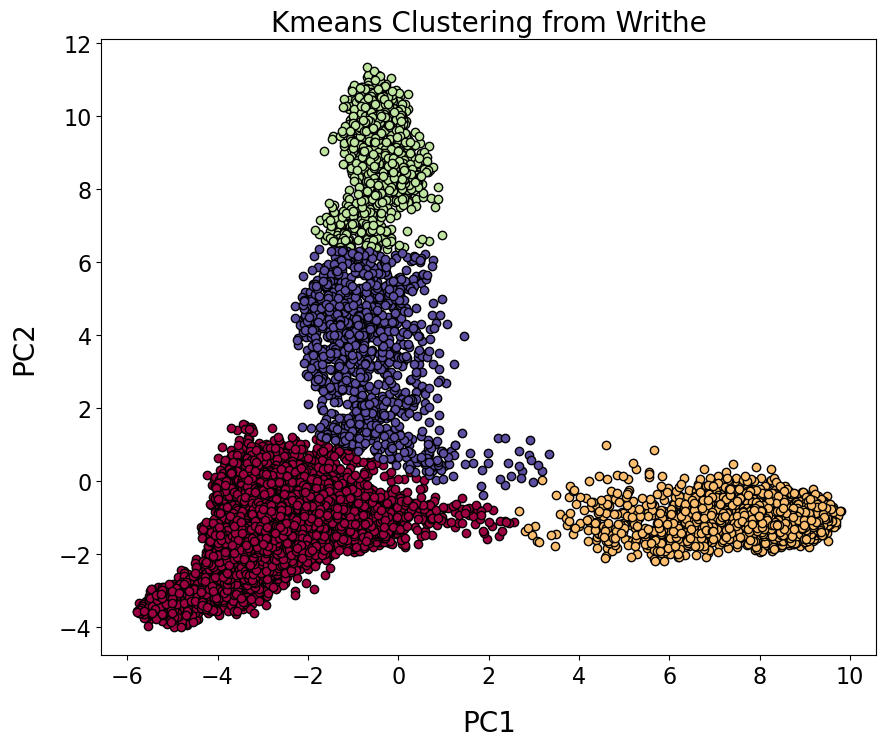

In [68]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

    """xy = X[class_member_mask] #  & ~core_samples_mask
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )"""
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Writhe", size = 20, loc="center")
#plt.savefig('./outdir/writhe_kmeans_clustering.png',dpi=200)

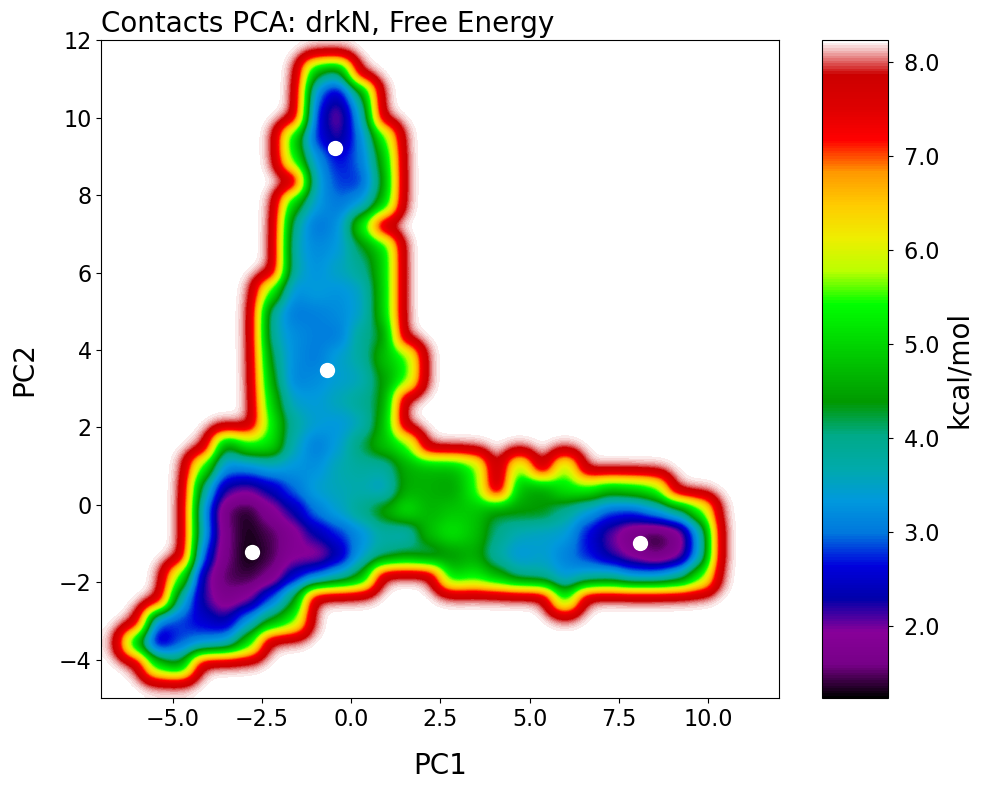

In [69]:
plt_free_energy(CPC1, CPC2, n_cmap, centers, True, "Contacts PCA: drkN, Free Energy", -7, 12, -5, 12)

In [70]:
# get every basin and save it 
cbasin1 = np.where(labels == 0)[0]
cbasin2 = np.where(labels == 1)[0]
cbasin3 = np.where(labels == 2)[0]
cbasin4 = np.where(labels == 3)[0]
cbasin5 = np.where(labels == 4)[0]
contacts_basin_trj = trj.slice(cbasin1)
contacts_basin_trj.save_dcd(outdir + "kmeans_contacts_basin1_trj.dcd")
contacts_basin_trj = trj.slice(cbasin2)
contacts_basin_trj.save_dcd(outdir + "kmeans_contacts_basin2_trj.dcd")
contacts_basin_trj = trj.slice(cbasin3)
contacts_basin_trj.save_dcd(outdir + "kmeans_contacts_basin3_trj.dcd")
contacts_basin_trj = trj.slice(cbasin4)
contacts_basin_trj.save_dcd(outdir + "kmeans_contacts_basin4_trj.dcd")
contacts_basin_trj = trj.slice(cbasin5)
contacts_basin_trj.save_dcd(outdir + "kmeans_contacts_basin5_trj.dcd")

In [ ]:
# HAVEN'T RUN BEYOND THIS 

In [ ]:
# check what size, since finding a centroid is O(n^2), you want to have ~ 4,000 datapoints
print(cbasin1.size/20, cbasin2.size/4, cbasin3.size/3, cbasin4.size/3, cbasin5.size/3)

In [ ]:
# get centroids 
traj_basin = md.load("./outdir/kmeans_contacts_basin5_trj.dcd", top=pdb, stride=3)
atom_indices = [a.index for a in traj_basin.topology.atoms if a.element.symbol != 'H']
distances = np.empty((traj_basin.n_frames, traj_basin.n_frames))
for i in range(traj_basin.n_frames):
    distances[i] = md.rmsd(traj_basin, traj_basin, i, atom_indices=atom_indices)

beta = 1
index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
print(index)

centroid = traj_basin[index]
print(centroid)

I wasn't able to calcualte the centroids for each basin trajectory b/c of the time, so here are the strides I used: 

- Basin 1: 551, stride 20 
- Basin 2: 1258, stride 3
- Basin 3: 411, stride 3
- Basin 4: 773, stride 3
- Basin 5: 614, stride 3 
Now, let's print out the average contactmap for each basin:

In [ ]:
c_matrx = writhe_avg_from_ind(wr_total, CAlabel, cbasin1)
plt_avg_matrx(c_matrx, title="Contacts, Average", count=0)

In [ ]:
c_matrx = writhe_avg_from_ind(wr_total, CAlabel, cbasin2)
plt_avg_matrx(c_matrx, title="Contacts, Average", count=0)

In [ ]:
c_matrx = writhe_avg_from_ind(wr_total, CAlabel, cbasin3)
plt_avg_matrx(c_matrx, title="Contacts, Average", count=0)

In [ ]:
c_matrx = writhe_avg_from_ind(wr_total, CAlabel, cbasin4)
plt_avg_matrx(c_matrx, title="Contacts, Average", count=0)

In [ ]:
c_matrx = writhe_avg_from_ind(wr_total, CAlabel, cbasin5)
plt_avg_matrx(c_matrx, title="Contacts, Average", count=0)

In [ ]:
# HAVE RUN THIS 

In [54]:
import math
    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

<ErrorbarContainer object of 3 artists>

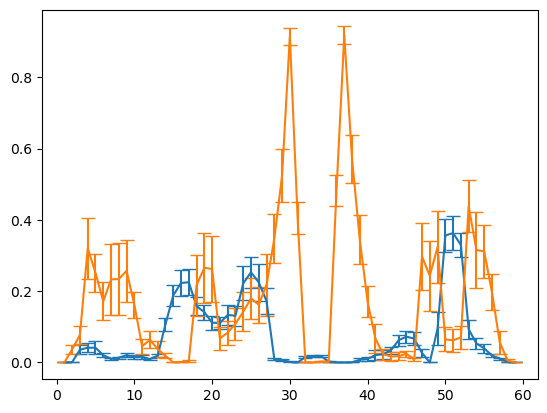

In [55]:
dssp=md.compute_dssp(trj, simplified=True)
#np.savetxt(wdir+"/dssp.out",dssp,fmt='%s')

dsspH=np.copy(dssp)
dsspE=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
#np.savetxt(wdir+"/dssp.HTOT.dat",TotalH,fmt='%i')

#Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
SE_H=np.zeros((len(CAlabel),2))

for i in range(0,len(CAlabel)): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 


dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 

Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
SE_E=np.zeros((len(CAlabel),2))

for i in range(0,len(CAlabel)):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
    
plt.errorbar(CAlabel,SE_H[:,0],yerr=SE_H[:,1], capsize=5)
plt.errorbar(CAlabel,SE_E[:,0],yerr=SE_E[:,1], capsize=5)

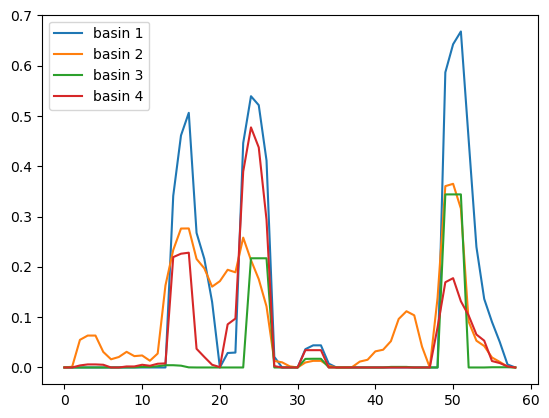

In [60]:
plt.plot(np.mean(dsspH[wbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspH[wbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspH[wbasin3],axis=0),label='basin 3')
plt.plot(np.mean(dsspH[wbasin4],axis=0),label='basin 4')
#plt.plot(np.mean(dsspH[basin5],axis=0),label='basin 5')
plt.legend()

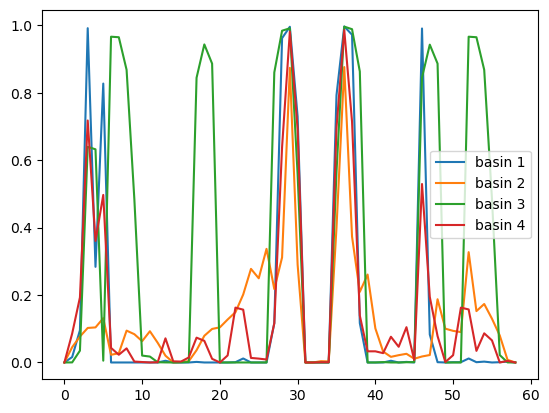

In [61]:
plt.plot(np.mean(dsspE[wbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspE[wbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspE[wbasin3],axis=0),label='basin 3')
plt.plot(np.mean(dsspE[wbasin4],axis=0),label='basin 4')
#plt.plot(np.mean(dsspE[basin5],axis=0),label='basin 5')
plt.legend()

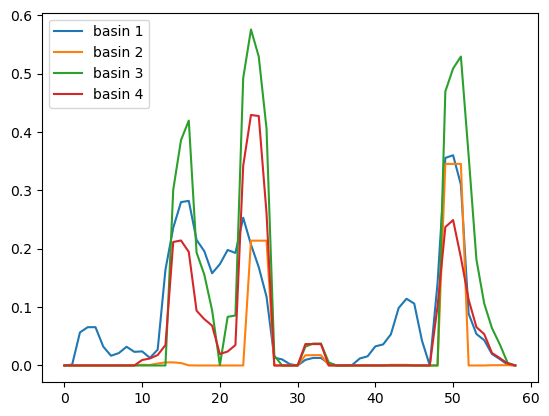

In [71]:
plt.plot(np.mean(dsspH[cbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspH[cbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspH[cbasin3],axis=0),label='basin 3')
plt.plot(np.mean(dsspH[cbasin4],axis=0),label='basin 4')
#plt.plot(np.mean(dsspH[cbasin5],axis=0),label='basin 5')
plt.legend()

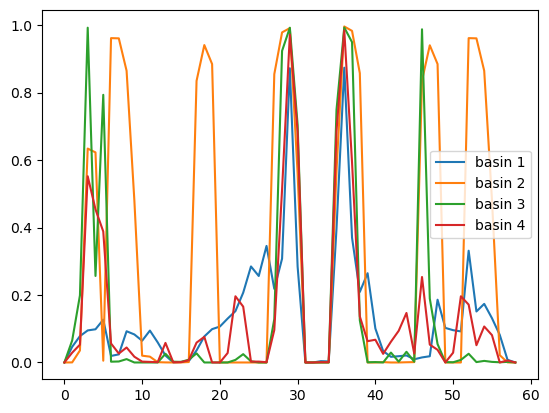

In [72]:
plt.plot(np.mean(dsspE[cbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspE[cbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspE[cbasin3],axis=0),label='basin 3')
plt.plot(np.mean(dsspE[cbasin4],axis=0),label='basin 4')
#plt.plot(np.mean(dsspE[cbasin5],axis=0),label='basin 5')
plt.legend()